# NBA Shots Dataset Cleaning and Preprocessing

This notebook outlines the comprehensive steps taken to clean and preprocess the NBA shots dataset, spanning the years 2019 to 2023. The dataset encompasses a wide array of features related to shots taken during NBA games, including player and team information, shot positions, and game contexts. The initial phase of cleaning ensures the data is accurate and free of anomalies, while the subsequent preprocessing phase transforms the data into a structured format, suitable for exploratory data analysis and machine learning modeling.

## Setup

Import necessary libraries and configure the environment for the data cleaning and preprocessing tasks.


In [1]:
# General utilities
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine learning utilities
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Deep learning utilities
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

Load the NBA shots data from CSV files for the years 2019 to 2023 and combine them into a single DataFrame.

In [2]:
years = [2015, 2019, 2020, 2021, 2022, 2023]
dfs = {'combined': pd.DataFrame()}  # Initialize a combined DataFrame

for year in years:
    file_path = f"data/NBA_{year}_Shots.csv"
    try:
        df = pd.read_csv(file_path)
        dfs[year] = df  # Store the DataFrame in the dictionary
        dfs['combined'] = pd.concat([dfs['combined'], df], ignore_index=True)  # Update the combined DataFrame
    except FileNotFoundError:
        print(f"The file 'NBA_{year}_Shots.csv' for {year} does not exist.")


# To select a specific year (e.g., 2020), you can access it like this:
df2015 = dfs[2015]
df2019 = dfs[2019]
df2020 = dfs[2020]
df2021 = dfs[2021]
df2022 = dfs[2022]
df2023 = dfs[2023]

# To select the combined data, you can access it like this:
dfcombined = dfs['combined']

## Data Cleaning

Identify and handle missing values in the dataset to ensure data quality for analysis.


In [3]:
# Check for missing values in each column
missing_values = dfcombined.isnull().sum()

# Print columns with missing values and their respective counts
print(missing_values[missing_values > 0])

POSITION_GROUP    5419
POSITION          5419
dtype: int64


In [4]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage = dfcombined[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows = dfcombined.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage, duplicate_rows)

(POSITION_GROUP    0.437705
 POSITION          0.437705
 dtype: float64,
 60)

In [5]:
# Detect outliers using Z-score

# Outlier detection for 'LOC_X'
z_scores_loc_x = np.abs(stats.zscore(dfcombined['LOC_X']))
outliers_loc_x = np.where(z_scores_loc_x > 3)
print(f"There are {len(outliers_loc_x[0])} outliers in the 'LOC_X' column.")

# Outlier detection for 'LOC_Y'
z_scores_loc_y = np.abs(stats.zscore(dfcombined['LOC_Y']))
outliers_loc_y = np.where(z_scores_loc_y > 3)
print(f"There are {len(outliers_loc_y[0])} outliers in the 'LOC_Y' column.")

# Outlier detection for 'SHOT_DISTANCE'
z_scores_shot_distance = np.abs(stats.zscore(dfcombined['SHOT_DISTANCE']))
outliers_shot_distance = np.where(z_scores_shot_distance > 3)
print(f"There are {len(outliers_shot_distance[0])} outliers in the 'SHOT_DISTANCE' column.")

There are 2842 outliers in the 'LOC_X' column.
There are 4186 outliers in the 'LOC_Y' column.
There are 2278 outliers in the 'SHOT_DISTANCE' column.


C:\Users\svaradappa\.conda\envs\notebook\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


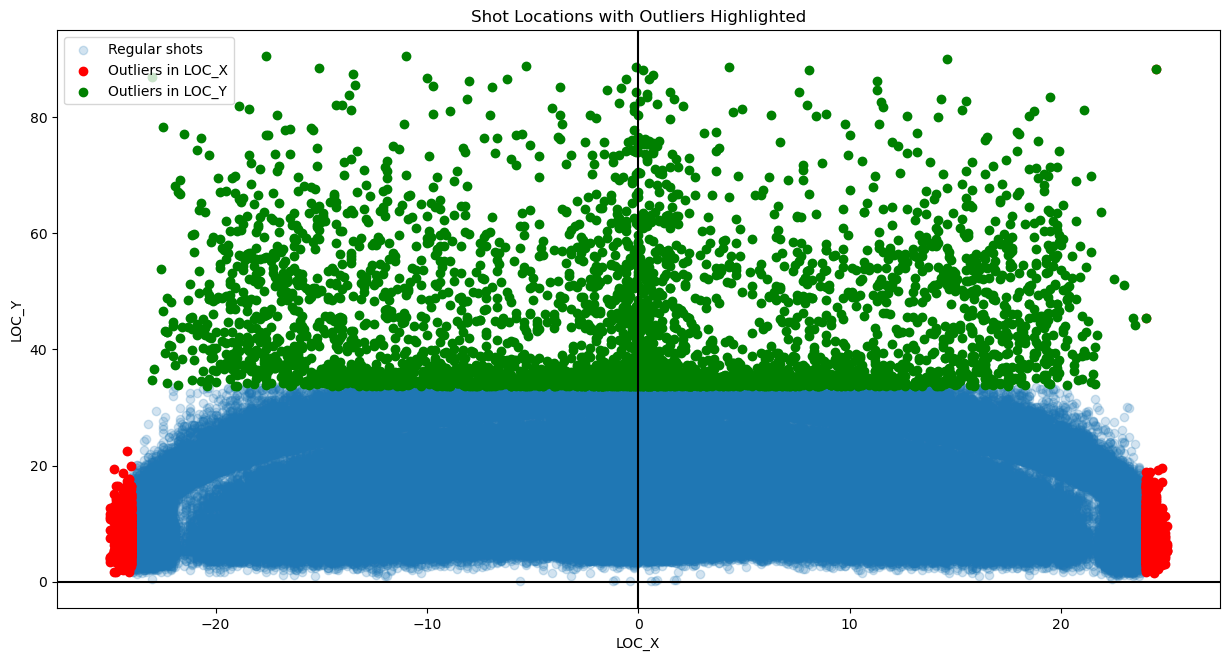

In [6]:
# Plotting LOC_X and LOC_Y to visualize shot locations
plt.figure(figsize=(15, 7.5))
# Plot a scatter plot of LOC_X and LOC_Y where the shots are made
plt.scatter(dfcombined['LOC_X'], dfcombined['LOC_Y'], alpha=0.2, label='Regular shots')
# Highlight the outliers
plt.scatter(dfcombined.loc[outliers_loc_x]['LOC_X'], dfcombined.loc[outliers_loc_x]['LOC_Y'], color='red', label='Outliers in LOC_X')
plt.scatter(dfcombined.loc[outliers_loc_y]['LOC_X'], dfcombined.loc[outliers_loc_y]['LOC_Y'], color='green', label='Outliers in LOC_Y')
plt.axhline(y=0, color='k')  # Add a line for the basket
plt.axvline(x=0, color='k')  # Center court line
plt.xlabel('LOC_X')
plt.ylabel('LOC_Y')
plt.title('Shot Locations with Outliers Highlighted')
plt.legend()
plt.show()

In [7]:
# Identify unique player names associated with each player ID
player_id_name = dfcombined.groupby('PLAYER_ID')['PLAYER_NAME'].unique()

# Identify player IDs with more than one associated name
inconsistent_players = player_id_name[player_id_name.apply(len) > 1]
print("Inconsistent Player IDs and names:")
print(inconsistent_players)

# Identify unique team names associated with each team ID
team_id_name = dfcombined.groupby('TEAM_ID')['TEAM_NAME'].unique()

# Identify team IDs with more than one associated name
inconsistent_teams = team_id_name[team_id_name.apply(len) > 1]
print("\nInconsistent Team IDs and names:")
print(inconsistent_teams)

Inconsistent Player IDs and names:
PLAYER_ID
1628384                   [O.G. Anunoby, OG Anunoby]
1628408                     [P.J. Dozier, PJ Dozier]
1630197    [Alekesej Pokusevski, Aleksej Pokusevski]
1630214         [Xavier Tillman Sr., Xavier Tillman]
1630288               [Jeff Dowtin, Jeff Dowtin Jr.]
1630527         [Brandon Boston, Brandon Boston Jr.]
Name: PLAYER_NAME, dtype: object

Inconsistent Team IDs and names:
TEAM_ID
1610612746    [Los Angeles Clippers, LA Clippers]
Name: TEAM_NAME, dtype: object


#### Analysis and Handling of Data Quality Issues
In the process of ensuring data quality for our NBA shots dataset, we have identified and addressed the following issues:

- Missing Values: The POSITION_GROUP and POSITION columns contain missing values, accounting for about 0.51% of the data. Due to the minimal impact, these rows have been removed.
- Duplicates: There are 60 instances of duplicate records. To maintain the dataset's integrity, these duplicates have been eliminated.
- Outliers: The LOC_X, LOC_Y, and SHOT_DISTANCE columns contain outliers. However, these values fall within the expected range of a basketball court and represent valid shot attempts, including less common long-range shots. Therefore, these outliers have been retained as they are crucial for a realistic representation of shot distribution.
- Inconsistent Player Names: The PLAYER ID and TEAM_ID columns had different ways of representing the same name

In [8]:
# Drop the duplicate rows
dfcombined_cleaned = dfcombined.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
dfcombined_cleaned = dfcombined_cleaned.dropna(subset=['POSITION_GROUP', 'POSITION'])

# Corrections for player names
player_name_corrections = {
    1630197: "Aleksej Pokusevski",
    1630527: "Brandon Boston Jr.",
    1628408: "PJ Dozier",
    1628384: "OG Anunoby",
    1630214: "Xavier Tillman Sr.",
    1630288: "Jeff Dowtin Jr."
}

# Apply the corrections for player names
dfcombined_cleaned['PLAYER_NAME'] = dfcombined_cleaned.apply(lambda row: player_name_corrections[row['PLAYER_ID']] if row['PLAYER_ID'] in player_name_corrections else row['PLAYER_NAME'], axis=1)

# Corrections for team names
team_name_corrections = {
    "LA Clippers": "Los Angeles Clippers"
}

# Apply the corrections for team names
dfcombined_cleaned['TEAM_NAME'] = dfcombined_cleaned['TEAM_NAME'].replace(team_name_corrections)

# Verify player name corrections
print("Corrected Player IDs and names:")
print(df.groupby('PLAYER_ID')['PLAYER_NAME'].unique())

# Verify team name corrections
print("\nCorrected Team IDs and names:")
print(df.groupby('TEAM_ID')['TEAM_NAME'].unique())

# Check if the cleaning was successful
cleaning_check = {
    "Remaining duplicates": dfcombined_cleaned.duplicated().sum(),
    "Remaining missing values": dfcombined_cleaned[['POSITION_GROUP', 'POSITION']].isnull().sum()
}

cleaning_check

Corrected Player IDs and names:
PLAYER_ID
2544             [LeBron James]
2617            [Udonis Haslem]
2738           [Andre Iguodala]
101108             [Chris Paul]
200752               [Rudy Gay]
                   ...         
1631323     [Simone Fontecchio]
1631367         [Jacob Gilyard]
1631466    [Jeenathan Williams]
1631495      [Donovan Williams]
1641645          [Xavier Cooks]
Name: PLAYER_NAME, Length: 537, dtype: object

Corrected Team IDs and names:
TEAM_ID
1610612737             [Atlanta Hawks]
1610612738            [Boston Celtics]
1610612739       [Cleveland Cavaliers]
1610612740      [New Orleans Pelicans]
1610612741             [Chicago Bulls]
1610612742          [Dallas Mavericks]
1610612743            [Denver Nuggets]
1610612744     [Golden State Warriors]
1610612745           [Houston Rockets]
1610612746               [LA Clippers]
1610612747        [Los Angeles Lakers]
1610612748                [Miami Heat]
1610612749           [Milwaukee Bucks]
1610612750    

{'Remaining duplicates': 0,
 'Remaining missing values': POSITION_GROUP    0
 POSITION          0
 dtype: int64}

## Data Preprocessing

##### Feature Description

Before transforming our features to be suitable for machine learning algorithms, let's summarize the characteristics of our numeric and categorical variables post-cleaning:

###### **Numeric Variables**
- There are 1,027,134 entries after cleaning.
- The SEASON_1 column, which seems to represent the year, ranges from 2019 to 2023.
- The SHOT_DISTANCE ranges from 0 to 88 feet, with a mean of approximately 13.5 feet.
- LOC_X and LOC_Y seem to represent the coordinates of the shot, with means close to 0, indicating that shots are spread around the basket.
- QUARTER ranges from 1 to 8, which may include overtime quarters.
- MINS_LEFT and SECS_LEFT show the time left in the quarter when the shot was taken.
###### **Categorical Variables**
- The dataset spans 5 seasons (SEASON_2), with '2018-19' being the most frequent season represented.
- TEAM_NAME and PLAYER_NAME have 31 and 948 unique entries, respectively, indicating the teams and players involved in the shots.
- Most shots were taken by guards (POSITION_GROUP) and specifically shooting guards (POSITION).
- The most common EVENT_TYPE is 'Missed Shot', which corresponds with the SHOT_MADE boolean column where False (missed shot) is more common than True (made shot).
- ACTION_TYPE has 48 unique types with 'Jump Shot' being the most common.
- The SHOT_TYPE indicates whether it was a 2-point or 3-point field goal.
- The BASIC_ZONE, ZONE_NAME, and ZONE_ABB columns describe the court area from which the shot was taken, with 'Restricted Area' and 'Center' being the most common zones.
- The ZONE_RANGE describes the distance category of the shot, with 'Less Than 8 ft.' being the most frequent.

#### Feature Transformation & Engineering

In this section, we map the categorical identifiers such as team IDs, player IDs, and zone abbreviations to their respective names for better interpretability. Additionally, we create a binary `IS_HOME_TEAM` column to indicate whether the team is playing at home, which simplifies the feature and reduces memory usage for future processing. This step is crucial for preparing the dataset for machine learning models, as it converts textual categorical data into a numerical format that can be easily processed by algorithms.

In [9]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids = dfcombined_cleaned['TEAM_ID'].unique()

# Extract unique team names
unique_team_names = dfcombined_cleaned['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams = dfcombined_cleaned['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids = dfcombined_cleaned['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names = dfcombined_cleaned['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names = dfcombined_cleaned['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb = dfcombined_cleaned['ZONE_ABB'].unique()

In [10]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping = dict(zip(unique_team_ids, unique_team_names))
team_abbreviation_to_id_mapping = dict(zip(unique_home_teams, unique_team_ids))
player_id_to_name_mapping = dict(zip(unique_player_ids, unique_player_names))
zone_abb_to_zonename_mapping = dict(zip(unique_zone_abb, unique_zone_names))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
dfcombined_cleaned['Home_Team_ID'] = dfcombined_cleaned['HOME_TEAM'].map(team_abbr_to_id)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
dfcombined_cleaned['IS_HOME_TEAM'] = (dfcombined_cleaned['Home_Team_ID'] == dfcombined_cleaned['TEAM_ID']).astype(int)

# The DataFrame dfcombined_cleaned now has a binary 'Is_Home_Team' column indicating home (1) and away (0) games.
dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.4,6.75,1,4,0,18,1610612756,0
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.0,5.35,0,4,0,22,1610612756,0
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,04-15-2015,21401225,...,C,Less Than 8 ft.,-0.0,5.35,0,5,0,3,1610612757,0
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,04-15-2015,21401229,...,C,Less Than 8 ft.,-0.0,5.35,0,4,0,37,1610612756,0
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,04-15-2015,21401229,...,L,16-24 ft.,16.9,14.85,19,4,0,48,1610612756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,C,Less Than 8 ft.,-2.1,7.45,3,4,1,37,1610612764,0
1238045,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,04-09-2023,22201216,...,RC,24+ ft.,-14.5,26.45,25,4,1,12,1610612764,0
1238046,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,Less Than 8 ft.,2.0,7.55,3,4,1,2,1610612764,0
1238047,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,04-09-2023,22201216,...,C,24+ ft.,0.2,30.85,25,4,0,28,1610612764,0


#### Date Feature Engineering
The GAME_DATE column is converted to a datetime object to extract additional features that may be relevant for analysis, such as the day of the week and month of the game. The year is already given in SEASON_1 column.

In [11]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
dfcombined_cleaned['GAME_DATE'] = pd.to_datetime(dfcombined_cleaned['GAME_DATE'])

# Extracting the month as a number (1-12)
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
dfcombined_cleaned['DAY'] = dfcombined_cleaned['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['GAME_DATE'].dt.dayofweek + 1

dfcombined_cleaned

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,Home_Team_ID,IS_HOME_TEAM,MONTH,DAY,WEEKDAY
0,2015,2014-15,1610612743,Denver Nuggets,203115,Will Barton,G,SG,2015-04-15,21401229,...,6.75,1,4,0,18,1610612756,0,4,15,3
1,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,22,1610612756,0,4,15,3
2,2015,2014-15,1610612739,Cleveland Cavaliers,1890,Shawn Marion,F,SF,2015-04-15,21401225,...,5.35,0,5,0,3,1610612757,0,4,15,3
3,2015,2014-15,1610612744,Golden State Warriors,203949,James Michael McAdoo,F,PF,2015-04-15,21401229,...,5.35,0,4,0,37,1610612756,0,4,15,3
4,2015,2014-15,1610612743,Denver Nuggets,203475,Erick Green,G,PG,2015-04-15,21401229,...,14.85,19,4,0,48,1610612756,0,4,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,7.45,3,4,1,37,1610612764,0,4,9,7
1238045,2023,2022-23,1610612737,Atlanta Hawks,1631495,Donovan Williams,G,SG,2023-04-09,22201216,...,26.45,25,4,1,12,1610612764,0,4,9,7
1238046,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,7.55,3,4,1,2,1610612764,0,4,9,7
1238047,2023,2022-23,1610612737,Atlanta Hawks,1628981,Bruno Fernando,C,C,2023-04-09,22201216,...,30.85,25,4,0,28,1610612764,0,4,9,7


#### Creation of TIME_LEFT Column

The `TIME_LEFT` column is computed by converting the minutes left (`MINS_LEFT`) to seconds and adding the remaining seconds (`SECS_LEFT`). This transformation facilitates the analysis of time-related patterns in the data by representing the time left in the game as a single numeric value in seconds.


In [12]:
# Convert 'MINS_LEFT' to seconds and add 'SECS_LEFT' to create 'TIME_LEFT' in seconds
dfcombined_cleaned['TIME_LEFT'] = dfcombined_cleaned['MINS_LEFT'] * 60 + dfcombined_cleaned['SECS_LEFT']

#### Creation of TOTAL_TIME_LEFT
This code computes the `TOTAL_TIME_LEFT` column, representing the remaining game time in seconds, inclusive of both regular quarters and overtime periods. For regular quarters (1st to 4th), it calculates the total time left by multiplying the number of full quarters remaining by 12 minutes (converted to seconds), and adding the minutes and seconds left in the current quarter. For overtime periods (quarters beyond the 4th), it directly converts the minutes left to seconds and adds the remaining seconds. This results in a uniform representation of time left across all game stages.

In [13]:
# TOTAL_TIME_LEFT including overtime
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

#### Normalization of LOC_X and LOC_Y
LOC_X and LOC_Y show different scalings throughout the year. This makes it hard to compare the different years, which is why in the following the values are being normalized to scale LOC_X and LOC_Y to the scale of a basketball court.

In [14]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list = []
for season, group in dfcombined_cleaned.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
dfcombined_cleaned = pd.concat(df_list)

# Verify normalization by checking the range of values for the first season
dfcombined_cleaned[dfcombined_cleaned['SEASON_1'] == 2019][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


### Feature Reduction and Type Conversion

##### Reducing Redundant Features
To streamline the dataset, redundant or unnecessary features are removed. This includes dropping columns that are represented by other, more effective identifiers or that have been encoded into new features.

##### Columns Dropped
- `PLAYER_NAME` and `TEAM_NAME` are removed in favor of `PLAYER_ID` and `TEAM_ID`.
- `SEASON_2` is redundant due to `SEASON_1`, which will also be renamed to `SEASON` .
- `ZONE_NAME` is represented by `ZONE_ABB`.
- `EVENT_TYPE` is captured by the binary `SHOT_MADE`.
- `Game_ID` is excluded because it is specific to past games and will not be applicable for future shot predictions. It merely indicates that shots were taken in the same game, which is not useful for our predictive modeling.
- `Home_Team_ID`, `HOME_TEAM`, and `AWAY_TEAM` are removed as they have been replaced by the binary `Is_Home_Team` column, which simplifies the dataset and avoids duplicative information.
- `MINS_LEFT` and `SECS_LEFT` are consolidated into `TIME_LEFT` in seconds, which makes the original columns unnecessary.
- `GAME_DATE` is already captured in `SEASON`, `Month` and `Day` 

In [15]:
# Drop unecessary columns

dfcombined_cleaned = dfcombined_cleaned.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'GAME_ID', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE', 'LOC_X', 'LOC_Y'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
dfcombined_cleaned.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,...,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TIME_LEFT,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,True,Driving Layup Shot,2PT Field Goal,Restricted Area,C,...,1,4,0,4,15,3,18,18,-0.400000,6.870432
1,2015,1610612744,203949,F,PF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,...,0,4,0,4,15,3,22,22,0.000000,5.413068
2,2015,1610612739,1890,F,SF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,...,0,5,0,4,15,3,3,3,0.000000,5.413068
3,2015,1610612744,203949,F,PF,True,Slam Dunk Shot,2PT Field Goal,Restricted Area,C,...,0,4,0,4,15,3,37,37,0.000000,5.413068
4,2015,1610612743,203475,G,PG,False,Pullup Jump shot,2PT Field Goal,Mid-Range,L,...,19,4,0,4,15,3,48,48,16.900000,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,1610612737,1631495,G,SG,True,Running Layup Shot,2PT Field Goal,Restricted Area,C,...,3,4,0,4,9,7,97,97,-2.054108,7.977064
1238045,2023,1610612737,1631495,G,SG,False,Pullup Jump shot,3PT Field Goal,Above the Break 3,RC,...,25,4,0,4,9,7,72,72,-14.478958,28.458716
1238046,2023,1610612737,1628981,C,C,True,Alley Oop Layup shot,2PT Field Goal,Restricted Area,C,...,3,4,0,4,9,7,62,62,2.054108,8.084862
1238047,2023,1610612737,1628981,C,C,False,Jump Shot,3PT Field Goal,Above the Break 3,C,...,25,4,0,4,9,7,28,28,0.250501,33.201835


#### Type Conversion
Categorical columns are explicitly converted to categorical types to optimize memory usage and improve the performance of machine learning models.

In [16]:
# Convert SHOT_MADE to binary
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping = {'2PT Field Goal': 0, '3PT Field Goal': 1}
dfcombined_cleaned['SHOT_TYPE'] = dfcombined_cleaned['SHOT_TYPE'].map(shot_type_mapping)

# Convert SEASON and QUARTER to ordinal
season_order = sorted(dfcombined_cleaned['SEASON'].unique())
quarter_order = sorted(dfcombined_cleaned['QUARTER'].unique())
dfcombined_cleaned['SEASON'] = pd.Categorical(dfcombined_cleaned['SEASON'], categories=season_order, ordered=True)
dfcombined_cleaned['QUARTER'] = pd.Categorical(dfcombined_cleaned['QUARTER'], categories=quarter_order, ordered=True)

# Convert MONTH and WEEKDAY to categorical
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['MONTH'].astype('category')
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    dfcombined_cleaned[col] = dfcombined_cleaned[col].astype('category')
 
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,...,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TIME_LEFT,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,1,Driving Layup Shot,0,Restricted Area,C,...,1,4,0,4,15,3,18,18,-0.400000,6.870432
1,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,4,0,4,15,3,22,22,0.000000,5.413068
2,2015,1610612739,1890,F,SF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,5,0,4,15,3,3,3,0.000000,5.413068
3,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,4,0,4,15,3,37,37,0.000000,5.413068
4,2015,1610612743,203475,G,PG,0,Pullup Jump shot,0,Mid-Range,L,...,19,4,0,4,15,3,48,48,16.900000,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,1610612737,1631495,G,SG,1,Running Layup Shot,0,Restricted Area,C,...,3,4,0,4,9,7,97,97,-2.054108,7.977064
1238045,2023,1610612737,1631495,G,SG,0,Pullup Jump shot,1,Above the Break 3,RC,...,25,4,0,4,9,7,72,72,-14.478958,28.458716
1238046,2023,1610612737,1628981,C,C,1,Alley Oop Layup shot,0,Restricted Area,C,...,3,4,0,4,9,7,62,62,2.054108,8.084862
1238047,2023,1610612737,1628981,C,C,0,Jump Shot,1,Above the Break 3,C,...,25,4,0,4,9,7,28,28,0.250501,33.201835


#### Memory Optimization for Numerical Variables

##### Reducing Data Type Sizes
To enhance computational efficiency and reduce memory usage, numerical columns are cast to more memory-efficient data types. Float64 columns are converted to float32, and int64 columns are converted to int32.

In [17]:
# Convert binary columns to int32
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype('int32')
dfcombined_cleaned['IS_HOME_TEAM'] = dfcombined_cleaned['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
dfcombined_cleaned['DAY'] = dfcombined_cleaned['DAY'].astype('int32')
dfcombined_cleaned['TIME_LEFT'] = dfcombined_cleaned['TIME_LEFT'].astype('int32')
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned['TOTAL_TIME_LEFT'].astype('int32')
dfcombined_cleaned['SHOT_DISTANCE'] = dfcombined_cleaned['SHOT_DISTANCE'].astype('int32')

#### Data Integrity Check

##### Verifying Data Types and Cardinality
After preprocessing, it is crucial to verify that data types are correctly assigned and to understand the cardinality of categorical variables. This step ensures that the dataset is ready for encoding and further analysis.

In [18]:
#checking for Types and amount of unique values

dfcombined_cleaned.info()

# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

for col in categorical_columns:
    print(f"{col}: {dfcombined_cleaned[col].nunique()} unique values")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232570 entries, 0 to 1238048
Data columns (total 21 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   SEASON           1232570 non-null  category
 1   TEAM_ID          1232570 non-null  category
 2   PLAYER_ID        1232570 non-null  category
 3   POSITION_GROUP   1232570 non-null  category
 4   POSITION         1232570 non-null  category
 5   SHOT_MADE        1232570 non-null  int32   
 6   ACTION_TYPE      1232570 non-null  category
 7   SHOT_TYPE        1232570 non-null  int64   
 8   BASIC_ZONE       1232570 non-null  category
 9   ZONE_ABB         1232570 non-null  category
 10  ZONE_RANGE       1232570 non-null  category
 11  SHOT_DISTANCE    1232570 non-null  int32   
 12  QUARTER          1232570 non-null  category
 13  IS_HOME_TEAM     1232570 non-null  int32   
 14  MONTH            1232570 non-null  category
 15  DAY              1232570 non-null  int32   
 16  

In [44]:
#testing for different feature combinations
#dfcombined_cleaned = dfcombined_cleaned.drop(['TEAM_ID','POSITION_GROUP', 'POSITION','BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE'], axis=1)
#dfcombined_cleaned = dfcombined_cleaned.drop(['SHOT_TYPE', 'IS_HOME_TEAM'], axis=1)

In [20]:
dfcombined_cleaned

,SEASON,TEAM_ID,PLAYER_ID,POSITION_GROUP,POSITION,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,...,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,MONTH,DAY,WEEKDAY,TIME_LEFT,TOTAL_TIME_LEFT,NORM_LOC_X,NORM_LOC_Y
0,2015,1610612743,203115,G,SG,1,Driving Layup Shot,0,Restricted Area,C,...,1,4,0,4,15,3,18,18,-0.400000,6.870432
1,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,4,0,4,15,3,22,22,0.000000,5.413068
2,2015,1610612739,1890,F,SF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,5,0,4,15,3,3,3,0.000000,5.413068
3,2015,1610612744,203949,F,PF,1,Slam Dunk Shot,0,Restricted Area,C,...,0,4,0,4,15,3,37,37,0.000000,5.413068
4,2015,1610612743,203475,G,PG,0,Pullup Jump shot,0,Mid-Range,L,...,19,4,0,4,15,3,48,48,16.900000,15.302326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238044,2023,1610612737,1631495,G,SG,1,Running Layup Shot,0,Restricted Area,C,...,3,4,0,4,9,7,97,97,-2.054108,7.977064
1238045,2023,1610612737,1631495,G,SG,0,Pullup Jump shot,1,Above the Break 3,RC,...,25,4,0,4,9,7,72,72,-14.478958,28.458716
1238046,2023,1610612737,1628981,C,C,1,Alley Oop Layup shot,0,Restricted Area,C,...,3,4,0,4,9,7,62,62,2.054108,8.084862
1238047,2023,1610612737,1628981,C,C,0,Jump Shot,1,Above the Break 3,C,...,25,4,0,4,9,7,28,28,0.250501,33.201835


### Encoding
#### Ordinal Encoding
To utilize categorical features in machine learning models, we need to encode these features numerically. This process involves converting categories to a numerical format that preserves any inherent order in the categories.

In [21]:
# Ensure SEASON is an ordered categorical type
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

# Check the conversion
print(dfcombined_cleaned['QUARTER'].head())

0     Q4
1     Q4
2    OT1
3     Q4
4     Q4
Name: QUARTER, dtype: category
Categories (8, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'OT1' < 'OT2' < 'OT3' < 'OT4']


In [22]:
# Check if SEASON is ordered
print("SEASON ordered:", dfcombined_cleaned['SEASON'].cat.ordered)
print("SEASON categories:", dfcombined_cleaned['SEASON'].cat.categories)

# Check if QUARTER is ordered
print("QUARTER ordered:", dfcombined_cleaned['QUARTER'].cat.ordered)
print("QUARTER categories:", dfcombined_cleaned['QUARTER'].cat.categories)

SEASON ordered: True
SEASON categories: Int64Index([2015, 2019, 2020, 2021, 2022, 2023], dtype='int64')
QUARTER ordered: True
QUARTER categories: Index(['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], dtype='object')


In [23]:
# For SEASON
season_categories = dfcombined_cleaned['SEASON'].cat.categories
season_mapping = {k: v for k, v in enumerate(season_categories)}
print("Season encoding mapping:", season_mapping)

# For QUARTER
quarter_categories = dfcombined_cleaned['QUARTER'].cat.categories
quarter_mapping = {k: v for k, v in enumerate(quarter_categories)}
print("Quarter encoding mapping:", quarter_mapping)

Season encoding mapping: {0: 2015, 1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
Quarter encoding mapping: {0: 'Q1', 1: 'Q2', 2: 'Q3', 3: 'Q4', 4: 'OT1', 5: 'OT2', 6: 'OT3', 7: 'OT4'}


In [24]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.codes
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
dfcombined_cleaned['SEASON'] += 1
dfcombined_cleaned['QUARTER'] += 1

# Verify the conversion by checking the data types again
print(dfcombined_cleaned[['SEASON', 'QUARTER']].dtypes)

SEASON     int8
QUARTER    int8
dtype: object


#### One-Hot Encoding of Categorical Variables

##### Preparing Categorical Variables for Machine Learning
To facilitate the use of categorical data in machine learning models, we apply one-hot encoding. This process converts categorical variables into a binary matrix representation, which is essential for models that require numerical input.

##### Encoding Process
- Initialize the `OneHotEncoder`.
- Fit the encoder to the categorical columns and transform them into a sparse matrix to optimize memory.
- Create a new DataFrame with encoded variables.

##### Integrating Encoded Features
- The original categorical columns are dropped from the cleaned DataFrame.
- The new encoded features are concatenated with the remaining data.
- A final check is performed to ensure no missing values are introduced during this process.


In [25]:
# Define the categorical columns to be encoded
categorical_columns = ['POSITION_GROUP', 'POSITION',
'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY']

# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(dfcombined_cleaned[categorical_columns])

# Get feature names for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoded_columns)

# Reset the index of the original DataFrame if necessary
dfcombined_cleaned.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
dfcombined_cleaned = dfcombined_cleaned.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
dfcombined_cleaned = pd.concat([dfcombined_cleaned, encoded_df], axis=1)

# Check the first few rows of the resulting DataFrame
display(dfcombined_cleaned.head())

# Verify that there are no missing values after concatenation
missing_values_after = dfcombined_cleaned.isnull().sum()
print("Missing values after concatenation:\n", missing_values_after)

,SEASON,TEAM_ID,PLAYER_ID,SHOT_MADE,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,1610612743,203115,1,0,1,4,0,15,18,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1610612744,203949,1,0,0,4,0,15,22,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1610612739,1890,1,0,0,5,0,15,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1610612744,203949,1,0,0,4,0,15,37,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1610612743,203475,0,0,19,4,0,15,48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Missing values after concatenation:
 SEASON       0
TEAM_ID      0
PLAYER_ID    0
SHOT_MADE    0
SHOT_TYPE    0
            ..
WEEKDAY_3    0
WEEKDAY_4    0
WEEKDAY_5    0
WEEKDAY_6    0
WEEKDAY_7    0
Length: 130, dtype: int64


#### Mapping of Player and Team IDs for Embedding
To prepare for embedding player and team identifiers in our models, we first map these categorical variables to a continuous range of integers. This step is crucial for the embedding process, as it requires numerical input for efficient processing. This mapping standardizes the representation of players and teams, ensuring consistency across the dataset. It facilitates the embedding of these high-cardinality categorical variables into dense, lower-dimensional vectors in the neural network.

In [26]:
# Extract unique player and team IDs
unique_player_ids = dfcombined_cleaned['PLAYER_ID'].unique()
unique_team_ids = dfcombined_cleaned['TEAM_ID'].unique()

# Create mapping dictionaries
player_id_map = {id: i for i, id in enumerate(unique_player_ids)}
team_id_map = {id: i for i, id in enumerate(unique_team_ids)}

# Apply mappings to the DataFrame
dfcombined_cleaned['PLAYER_ID_MAPPED'] = dfcombined_cleaned['PLAYER_ID'].astype(int).map(player_id_map)
dfcombined_cleaned['TEAM_ID_MAPPED'] = dfcombined_cleaned['TEAM_ID'].astype(int).map(team_id_map)

# Verify the mapping ranges
print("Player ID mapping range:", dfcombined_cleaned['PLAYER_ID_MAPPED'].min(), "to", dfcombined_cleaned['PLAYER_ID_MAPPED'].max())
print("Team ID mapping range:", dfcombined_cleaned['TEAM_ID_MAPPED'].min(), "to", dfcombined_cleaned['TEAM_ID_MAPPED'].max())

Player ID mapping range: 0 to 1191
Team ID mapping range: 0 to 29


C:\Users\svaradappa\.conda\envs\notebook\lib\site-packages\ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\svaradappa\.conda\envs\notebook\lib\site-packages\ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


### Output

After data cleaning, transformation, and optimization, the dataset is now fully preprocessed. We have addressed missing values, removed duplicates, transformed categorical variables into a machine-learning-friendly format using one-hot encoding, and optimized memory usage by adjusting data types. The dataset is now primed for the next phase of our analysis, which involves feature selection and model development. This structured and clean dataset forms a solid foundation for building robust predictive models and extracting meaningful insights

In [27]:
# Separate the 2015 season data
df_2015 = dfcombined_cleaned[dfcombined_cleaned['SEASON'] == 1]
X_2015 = df_2015.drop(['SHOT_MADE'], axis=1)
y_2015 = df_2015['SHOT_MADE']

# For training, use data excluding the 2015 season
df_train = dfcombined_cleaned[dfcombined_cleaned['SEASON'] != 1]

# Seperate target variable and features
X = df_train.drop(['SHOT_MADE'], axis=1)  
y = df_train['SHOT_MADE']

X

,SEASON,TEAM_ID,PLAYER_ID,SHOT_TYPE,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TIME_LEFT,TOTAL_TIME_LEFT,...,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7,PLAYER_ID_MAPPED,TEAM_ID_MAPPED
205436,2,1610612762,1628960,1,23,5,1,10,18,18,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,489,8
205437,2,1610612746,1627820,0,11,5,0,10,27,27,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,490,29
205438,2,1610612737,1627752,1,32,4,0,10,2,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,491,16
205439,2,1610612762,1628513,0,2,5,1,10,46,46,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,492,8
205440,2,1610612746,203210,1,24,5,0,10,55,55,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,320,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232565,6,1610612737,1631495,0,3,4,0,9,97,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1191,16
1232566,6,1610612737,1631495,1,25,4,0,9,72,72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1191,16
1232567,6,1610612737,1628981,0,3,4,0,9,62,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,848,16
1232568,6,1610612737,1628981,1,25,4,0,9,28,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,848,16


In [28]:
dfcombined_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232570 entries, 0 to 1232569
Columns: 132 entries, SEASON to TEAM_ID_MAPPED
dtypes: Sparse[float32, 0](117), category(2), float64(2), int32(6), int64(3), int8(2)
memory usage: 156.4 MB


## Feedforward Neural Network
#### Data Splitting for Model Training and Evaluation
To ensure robust model evaluation and mitigate overfitting, the data is split into training, validation, and testing sets. This approach allows for a comprehensive assessment of the model's performance.

In [29]:
# Split the data into training, validation, and testing sets (80/10/10)
# Split the data into training and testing sets (80/20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the test data into test and validation sets (50/50 split, 10% validation 10% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Feature Scaling and Embedding Preparation for Neural Network

##### Feature Scaling
To ensure our neural network model can effectively learn from the data, we perform feature scaling on continuous variables. This is crucial for optimizing the neural network's learning process.

**Scaling Steps:**
1. Extract and separate `PLAYER_ID` and `TEAM_ID` for embedding, removing them from the main feature set.
2. Utilize `StandardScaler` to normalize continuous features like `SHOT_DISTANCE`, `TIME_LEFT`, ensuring they have a mean of zero and a standard deviation of one.
3. Apply the scaling transformation to the training, validation, and testing datasets.

##### Embedding Preparation
Embeddings are used to efficiently represent high-cardinality categorical variables like `PLAYER_ID` and `TEAM_ID`.

**Embedding Process:**
1. Define input layers for player and team IDs.
2. Create embedding layers for both players and teams, determining the embedding dimensions based on the square root of the number of unique values.
3. Flatten the outputs from the embedding layers.
4. Concatenate the flattened embeddings with other processed features, preparing them for input into the neural network model.

These steps optimize the data representation for the neural network, enabling it to capture complex relationships within high-dimensional categorical data.

In [30]:
# Extract PLAYER_ID and TEAM_ID for Embedding
player_ids_train = X_train['PLAYER_ID_MAPPED']
team_ids_train = X_train['TEAM_ID_MAPPED']
player_ids_val = X_val['PLAYER_ID_MAPPED']
team_ids_val = X_val['TEAM_ID_MAPPED']
player_ids_test = X_test['PLAYER_ID_MAPPED']
team_ids_test = X_test['TEAM_ID_MAPPED']

# Drop 'PLAYER_ID' and 'TEAM_ID' from the main features dataset for scaling
X_train = X_train.drop(['PLAYER_ID', 'TEAM_ID', 'PLAYER_ID_MAPPED', 'TEAM_ID_MAPPED'], axis=1)
X_val = X_val.drop(['PLAYER_ID', 'TEAM_ID', 'PLAYER_ID_MAPPED', 'TEAM_ID_MAPPED'], axis=1)
X_test = X_test.drop(['PLAYER_ID', 'TEAM_ID', 'PLAYER_ID_MAPPED', 'TEAM_ID_MAPPED'], axis=1)

# define continuous features
continuous_features = ['SHOT_DISTANCE', 'TIME_LEFT', 'TOTAL_TIME_LEFT', 'NORM_LOC_X', 'NORM_LOC_Y']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train[continuous_features])

# Make a copy of the dataframes to keep the original separate
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scale the continuous features of the training data
X_train_scaled[continuous_features] = scaler.transform(X_train[continuous_features])

# Apply the scaler to the continuous features of the validation and test data
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

# Now X_train_scaled, X_val_scaled, and X_test_scaled are ready for model training

In [31]:
# define the number of unique players and teams
num_unique_players = 1192
num_unique_teams = 30

player_embedding_dim = int(np.sqrt(num_unique_players)) 
team_embedding_dim = int(np.sqrt(num_unique_teams)) 

# Input layers for player and team IDs
player_input = Input(shape=(1,), name='player_input')
team_input = Input(shape=(1,), name='team_input')

# Embedding layers
player_embedding = Embedding(input_dim=num_unique_players, output_dim=player_embedding_dim, input_length=1, name='player_embedding')(player_input)
team_embedding = Embedding(input_dim=num_unique_teams, output_dim=team_embedding_dim, input_length=1, name='team_embedding')(team_input)

# Flatten the embedding output
player_embedding_flat = Flatten()(player_embedding)
team_embedding_flat = Flatten()(team_embedding)

# creating other features for concatenating
other_features_input = Input(shape=(X_train_scaled.shape[1],), name='other_features_input')

# Concatenate embeddings with other features
concatenated = concatenate([player_embedding_flat, team_embedding_flat, other_features_input])

#### Final FNN Model Configuration

After extensive hyperparameter tuning and evaluating various feature combinations, we arrived at our final neural network model configuration. This model yielded the best results and is characterized by the following:

**Model Configuration Highlights:**
1. **Hyperparameter Settings:** A refined approach was taken in setting the learning rate, dropout rate, and number of neurons. These adjustments were made after rigorous testing to find the most effective combination.
2. **Input Layers and Embeddings:** The model features distinct input layers for player and team IDs, along with other relevant features. Embedding layers were employed for player and team IDs, effectively compressing high-cardinality categorical data into dense, lower-dimensional vectors.
3. **Layer Architecture:** The network consists of dense layers using the ReLU activation function, known for its efficiency in training neural networks. The output layer employs a sigmoid activation function, suitable for binary classification tasks like shot prediction.

**Strategic Model Training:**
1. **Model Compilation:** Compiled using binary cross-entropy loss and the Adam optimizer, the model is fine-tuned for binary classification tasks.
2. **Regularization and Overfitting Prevention:** Dropout layers are incorporated as a regularization technique to prevent overfitting, a crucial consideration in achieving generalizable model performance.
3. **Early Stopping Mechanism:** An early stopping callback with a patience of 20 epochs is included to halt training if the validation loss does not improve, ensuring the model does not overfit to the training data.

**Performance Evaluation:**
1. The model's performance is evaluated on a separate test dataset, focusing on accuracy and loss metrics to gauge its predictive accuracy.
2. This final model configuration, the result of careful optimization and feature selection, represents our best effort in creating an effective tool for NBA shot prediction.

In [32]:
# Hyperparameters
learning_rate = 0.0001  # Adjusted learning rate
dropout_rate = 0.4      # Adjusted dropout rate
additional_neurons = 64 # Additional neurons for added complexity

# Define inputs
player_input = Input(shape=(1,), name='player_input')
team_input = Input(shape=(1,), name='team_input')
other_features_input = Input(shape=(X_train_scaled.shape[1],), name='other_features_input')

# Embeddings
player_embedding = Embedding(input_dim=1192, output_dim=30, input_length=1, name='player_embedding')(player_input)
team_embedding = Embedding(input_dim=30, output_dim=5, input_length=1, name='team_embedding')(team_input)

# Flatten embeddings
player_embedding_flat = Flatten()(player_embedding)
team_embedding_flat = Flatten()(team_embedding)

# Concatenate features
concatenated = concatenate([player_embedding_flat, team_embedding_flat, other_features_input])

# Neural network layers
hidden_layer1 = Dense(64, activation='relu')(concatenated)
dropout_layer1 = Dropout(dropout_rate)(hidden_layer1)
hidden_layer2 = Dense(additional_neurons, activation='relu')(dropout_layer1)
dropout_layer2 = Dropout(dropout_rate)(hidden_layer2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

# Create and compile the model
model = Model(inputs=[player_input, team_input, other_features_input], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    [player_ids_train, team_ids_train, X_train_scaled], y_train,
    validation_data=([player_ids_val, team_ids_val, X_val_scaled], y_val),
    epochs=50, batch_size=128, callbacks=[early_stopping], verbose=2
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([player_ids_test, team_ids_test, X_test_scaled], y_test, verbose=2)
print(f'\nTest accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 player_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 team_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 player_embedding (Embedding)   (None, 1, 30)        35760       ['player_input[0][0]']           
                                                                                                  
 team_embedding (Embedding)     (None, 1, 5)         150         ['team_input[0][0]']             
                                                                                              

Epoch 39/50
6420/6420 - 42s - loss: 0.6294 - accuracy: 0.6427 - val_loss: 0.6335 - val_accuracy: 0.6360 - 42s/epoch - 7ms/step
Epoch 40/50
6420/6420 - 35s - loss: 0.6292 - accuracy: 0.6428 - val_loss: 0.6335 - val_accuracy: 0.6362 - 35s/epoch - 5ms/step
Epoch 41/50
6420/6420 - 37s - loss: 0.6290 - accuracy: 0.6432 - val_loss: 0.6335 - val_accuracy: 0.6367 - 37s/epoch - 6ms/step
Epoch 42/50
6420/6420 - 38s - loss: 0.6290 - accuracy: 0.6430 - val_loss: 0.6336 - val_accuracy: 0.6368 - 38s/epoch - 6ms/step
Epoch 43/50
6420/6420 - 41s - loss: 0.6288 - accuracy: 0.6434 - val_loss: 0.6337 - val_accuracy: 0.6369 - 41s/epoch - 6ms/step
Epoch 44/50
6420/6420 - 48s - loss: 0.6287 - accuracy: 0.6437 - val_loss: 0.6338 - val_accuracy: 0.6361 - 48s/epoch - 7ms/step
Epoch 45/50
6420/6420 - 48s - loss: 0.6288 - accuracy: 0.6439 - val_loss: 0.6337 - val_accuracy: 0.6367 - 48s/epoch - 8ms/step
Epoch 46/50
6420/6420 - 38s - loss: 0.6286 - accuracy: 0.6438 - val_loss: 0.6337 - val_accuracy: 0.6363 - 38s/e

In [35]:
# Prepare the 2015 data
player_ids_2015 = X_2015['PLAYER_ID_MAPPED']
team_ids_2015 = X_2015['TEAM_ID_MAPPED']
X_2015_scaled = X_2015.drop(['PLAYER_ID', 'TEAM_ID', 'PLAYER_ID_MAPPED', 'TEAM_ID_MAPPED'], axis=1)
X_2015_scaled[continuous_features] = scaler.transform(X_2015_scaled[continuous_features])

test2015_loss, test2015_accuracy = model.evaluate([player_ids_2015, team_ids_2015, X_2015_scaled], y_2015)
print(f'\nTest accuracy: {test2015_accuracy:.4f}, Test loss: {test2015_loss:.4f}')

6420/6420 [==============================] - 16s 3ms/step - loss: 0.6460 - accuracy: 0.6277

Test accuracy: 0.6277, Test loss: 0.6460


In [37]:
def evaluate_model(model, player_ids, team_ids, features, true_labels):
    # Predict probabilities
    predicted_probs = model.predict([player_ids, team_ids, features])

    # Calculate ROC AUC Score
    auc_score = roc_auc_score(true_labels, predicted_probs)

    # Convert probabilities to binary predictions
    predicted_labels = (predicted_probs > 0.5).astype("int32")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    return auc_score, conf_matrix

# Prepare data for 2019-2023 test set
player_ids_test_2019_2023 = player_ids_test
team_ids_test_2019_2023 = team_ids_test
X_test_scaled_2019_2023 = X_test_scaled
y_test_2019_2023 = y_test

# Evaluate model on 2019-2023 test set
auc_2019_2023, conf_matrix_2019_2023 = evaluate_model(model, player_ids_test_2019_2023, team_ids_test_2019_2023, X_test_scaled_2019_2023, y_test_2019_2023)

# Prepare data for 2015 test set
player_ids_test_2015 = player_ids_2015
team_ids_test_2015 = team_ids_2015
X_test_scaled_2015 = X_2015_scaled
y_test_2015 = y_2015

# Evaluate model on 2015 test set
auc_2015, conf_matrix_2015 = evaluate_model(model, player_ids_test_2015, team_ids_test_2015, X_test_scaled_2015, y_test_2015)

# Print results
print("2019-2023 Test Set:\nROC AUC Score:", auc_2019_2023, "\nConfusion Matrix:\n", conf_matrix_2019_2023)
print("\n2015 Test Set:\nROC AUC Score:", auc_2015, "\nConfusion Matrix:\n", conf_matrix_2015)

6420/6420 [==============================] - 16s 3ms/step
2019-2023 Test Set:
ROC AUC Score: 0.6661583891650732 
Confusion Matrix:
 [[45629  9129]
 [28172 19784]]

2015 Test Set:
ROC AUC Score: 0.6603172344006197 
Confusion Matrix:
 [[101583  11619]
 [ 64855  27379]]


#### Model Performance Evaluation

Our Feedforward Neural Network (FNN) model underwent comprehensive testing on two datasets: the 2019-2023 dataset and the completely unseen 2015 dataset. The results of these evaluations are as follows:

**2019-2023 Test Set:**
- Final Test Accuracy: 63.68%
- Final Test Loss: 0.6342
- ROC AUC Score: 0.6662
- Confusion Matrix: 
  - True Positives: 19,784
  - True Negatives: 45,629
  - False Positives: 9,129
  - False Negatives: 28,172

**2015 Unseen Dataset:**
- Test Accuracy: 62.77%
- Test Loss: 0.6460
- ROC AUC Score: 0.6603
- Confusion Matrix: 
  - True Positives: 27,379
  - True Negatives: 101,583
  - False Positives: 11,619
  - False Negatives: 64,855

These results indicate that the model has effectively learned to predict shot outcomes with a reasonable degree of accuracy across both the recent and historical datasets. The inclusion of ROC AUC scores and confusion matrices provide additional insight into the model's performance, demonstrating its reliability in predicting NBA shot success. The training and validation process, along with the results on the test sets, affirm the model's efficacy in the context of basketball analytics.

In [38]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_

# Map features to their importance
feature_importances = sorted(zip(importances, X_train_scaled.columns), reverse=True)

# Display the feature importances
for importance, feature in feature_importances[:20]:  # Display top 20 features
    print(f"{feature}: {importance}")

C:\Users\svaradappa\.conda\envs\notebook\lib\site-packages\sklearn\utils\validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


NORM_LOC_Y: 0.1208853424463493
TIME_LEFT: 0.12077516260242425
TOTAL_TIME_LEFT: 0.1198907153262318
NORM_LOC_X: 0.11372353017550604
DAY: 0.08849901451055688
SHOT_DISTANCE: 0.056621602679228215
SEASON: 0.038138229565837636
QUARTER: 0.03444213933878016
BASIC_ZONE_Restricted Area: 0.0127562527922384
MONTH_1: 0.01152158470095809
WEEKDAY_3: 0.011366439256472918
WEEKDAY_5: 0.011311757984806669
MONTH_12: 0.01054174127104017
MONTH_3: 0.010521092297362377
WEEKDAY_1: 0.010432248995714051
WEEKDAY_6: 0.01036440931732934
MONTH_2: 0.010358214069617394
WEEKDAY_7: 0.01010524639868183
MONTH_11: 0.009945538706641005
WEEKDAY_2: 0.00915954155816223


#### Feature Importance Analysis and Feature Selection Strategy

Our model development process included a feature importance analysis using a Random Forest classifier. This analysis initially guided us in exploring various combinations of features for the Feedforward Neural Network (FNN) model, based on their predictive significance for NBA shot success. Key features such as normalized player location coordinates (NORM_LOC_X, NORM_LOC_Y), time-related features (TIME_LEFT, TOTAL_TIME_LEFT), and date-related features (DAY) were identified as particularly influential.

However, during the course of model tuning and testing, we discovered that incorporating the entire set of features resulted in the most effective predictive performance. This approach allowed the FNN to leverage the full spectrum of available data, enhancing its ability to discern complex patterns and interactions. As a result, our final FNN model utilized all available features, a decision that was substantiated by improved model accuracy.

Note: Detailed feature importance data and the iterative process of feature combination testing are not included in this summary for conciseness. This markdown highlights the evolution of our feature selection strategy, culminating in the use of a comprehensive feature set for optimal model performance.

### Summary of NBA Shot Prediction Analysis

This thesis project applied a Feedforward Neural Network (FNN) model to predict NBA shot outcomes, leveraging data from the 2019-2023 seasons and testing on an unseen 2015 dataset. Our model, enhanced by comprehensive feature scaling, embedding preparation, and hyperparameter tuning, demonstrated promising predictive performance.

Key Takeaways:
- The FNN model achieved an accuracy of 63.68% on the 2019-2023 dataset and 62.77% on the 2015 dataset, validating its effectiveness in basketball shot prediction.
- Extensive testing of various feature combinations revealed that utilizing all 131 available features yielded the best results. The FNN's ability to assign appropriate weights during training ensured the effectiveness of this comprehensive feature set.
- Our analysis suggests that while increasing the volume of data and extensive hyperparameter tuning provided marginal improvements, the integration of a wide range of categorical data significantly enhanced model accuracy.
- The model's robust performance across both current and historical datasets underscores its potential utility in sports analytics.

This work contributes to the evolving field of sports analytics by demonstrating the application of advanced machine learning techniques in predicting complex, real-world events like NBA shots. Future research could further explore the integration of more nuanced game-specific data and advanced data preprocessing methods to refine predictive models in sports analytics.